In [30]:
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row
import pandas as pd
import numpy as np

from pyspark.sql.functions import when, udf, col, regexp_replace
from pyspark.sql.types import DoubleType,IntegerType, StringType
import pyspark.sql.functions as F

In [2]:
sc = SparkContext('local')
sqlCtx = SQLContext(sc)

In [3]:
df = sqlCtx.read.csv('../data/births.txt', inferSchema = True)
df

DataFrame[_c0: int, _c1: double, _c2: double]

In [7]:
# 분산 데이터프레잉을 반환하기 때문에 함수를 이어 쓰기

df = df.withColumnRenamed('_c0', 'year').withColumnRenamed('_c1', 'boys').withColumnRenamed('_c2', 'girls')

In [8]:
df.show()

+----+--------+--------+
|year|    boys|   girls|
+----+--------+--------+
|1880| 90993.0|110491.0|
|1881| 91954.0|100745.0|
|1882|107850.0|113688.0|
|1883|112321.0|104629.0|
|1884|129022.0|114445.0|
|1885|133055.0|107800.0|
|1886|144535.0|110784.0|
|1887|145982.0|101414.0|
|1888|178627.0|120853.0|
|1889|178366.0|110584.0|
|1890|190377.0|111025.0|
|1891|185482.0|101196.0|
|1892|212346.0|122037.0|
|1893|212906.0|112317.0|
|1894|222922.0|115772.0|
|1895|233630.0|117398.0|
|1896|237920.0|119570.0|
|1897|234202.0|112758.0|
|1898|258770.0|122693.0|
|1899|233023.0|106212.0|
+----+--------+--------+
only showing top 20 rows



In [9]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- boys: double (nullable = true)
 |-- girls: double (nullable = true)



<pre>
1. 2000년도 이후 데이터를 구하시요
2. 1995~2000 년도 데이터를 구하시요
3.  남아출생이 가장많은 top5를 
구하시요(년도,남아수 출력)
4. 남아율(%)컬럼을 추가하고 각년도별
남아수가 차지하는 비율을 보여주시요
5. 2000년도 이후 데이터를 바차트로 보여주시요
</pre>

# 1. 2000년도 이후 데이터를 구하시요

In [47]:
a=2000
df.where(f'year >= {a}').show()

+----+---------+---------+
|year|     boys|    girls|
+----+---------+---------+
|2000|1814601.0|1962406.0|
|2001|1799049.0|1941251.0|
|2002|1795206.0|1939815.0|
|2003|1825359.0|1973434.0|
|2004|1834145.0|1982794.0|
|2005|1845379.0|1994841.0|
|2006|1898463.0|2052377.0|
|2007|1919408.0|2072139.0|
|2008|1887234.0|2036289.0|
|2009|1832925.0|1979303.0|
|2010|1772738.0|1913851.0|
|2011|1753500.0|1893230.0|
+----+---------+---------+



# 2. 1995~2000 년도 데이터를 구하시요

In [49]:
a=1995
b=2000
df.where(f'year between {a} and {b}').show()

+----+---------+---------+
|year|     boys|    girls|
+----+---------+---------+
|1995|1757927.0|1902832.0|
|1996|1752249.0|1893378.0|
|1997|1739806.0|1884122.0|
|1998|1765915.0|1910250.0|
|1999|1772632.0|1918809.0|
|2000|1814601.0|1962406.0|
+----+---------+---------+



# 3.  남아출생이 가장많은 top5를 구하시요(년도,남아수 출력)

In [50]:
df.select('year','boys').orderBy('boys', ascending= False ).show(5)

+----+---------+
|year|     boys|
+----+---------+
|1957|2044160.0|
|1959|2023044.0|
|1960|2022093.0|
|1961|2017316.0|
|1958|2010884.0|
+----+---------+
only showing top 5 rows



#### 또는

In [51]:
for r in df.orderBy('boys', ascending = False).head(5):
    print(r['year'], r['boys'])

1957 2044160.0
1959 2023044.0
1960 2022093.0
1961 2017316.0
1958 2010884.0


# 4. 남아율(%)컬럼을 추가하고 각년도별 남아수가 차지하는 비율을 보여주시요

In [21]:
df.withColumn('남아율(%)', (df['boys']/ (df['boys'] +df['girls']))*100).show()

+----+--------+--------+------------------+
|year|    boys|   girls|         남아율(%)|
+----+--------+--------+------------------+
|1880| 90993.0|110491.0| 45.16140239423478|
|1881| 91954.0|100745.0|47.718981416613474|
|1882|107850.0|113688.0| 48.68239308831893|
|1883|112321.0|104629.0|51.772758700161326|
|1884|129022.0|114445.0| 52.99362952679418|
|1885|133055.0|107800.0| 55.24278092628345|
|1886|144535.0|110784.0| 56.60957468891857|
|1887|145982.0|101414.0| 59.00742130026354|
|1888|178627.0|120853.0| 59.64571924669427|
|1889|178366.0|110584.0|  61.7290188613947|
|1890|190377.0|111025.0| 63.16381444051466|
|1891|185482.0|101196.0| 64.70046533044042|
|1892|212346.0|122037.0| 63.50382645050735|
|1893|212906.0|112317.0|  65.4646196609711|
|1894|222922.0|115772.0| 65.81811310504467|
|1895|233630.0|117398.0| 66.55594425515913|
|1896|237920.0|119570.0| 66.55291057092506|
|1897|234202.0|112758.0| 67.50115287064791|
|1898|258770.0|122693.0| 67.83619905469207|
|1899|233023.0|106212.0|  68.690730

# 5. 2000년도 이후 데이터를 바차트로 보여주시요

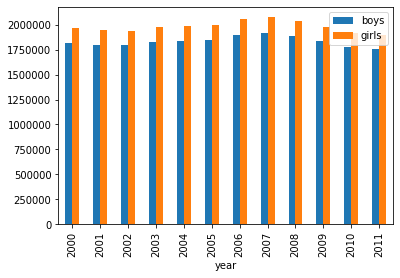

In [52]:
df_pd = df.where('year>=2000').toPandas()
df_pd.set_index('year', inplace=True)
df_pd.plot(kind='bar')

# ===========================

# 집계함수

### 집계함수를 쓸 때 agg함수 사용
### 칼럼명, 집계함수 -> 문자열로 주기
### 통계 관련 함수는 Hive ql에 있음

### https://rfriend.tistory.com/213 : hive ql 함수

In [33]:
df.agg({'girls':'sum'}).show()

+------------+
|  sum(girls)|
+------------+
|1.64392696E8|
+------------+



In [34]:
df.agg({'girls':'sum'}).toPandas()

,sum(girls)
0,164392696.0


In [39]:
df.agg({'girls':'sum'}).toPandas().loc[0]['sum(girls)']

164392696.0

In [38]:
df.agg({'girls':'sum'}).collect()

[Row(sum(girls)=164392696.0)]

In [37]:
# 0인덱스의 합만 추출
df.agg({'girls':'sum'}).collect()[0]['sum(girls)']

164392696.0

In [40]:
df.agg(F.sum('girls')).show()

+------------+
|  sum(girls)|
+------------+
|1.64392696E8|
+------------+



In [42]:
df.agg({'girls':'sum', 'boys':'mean'}).show()

+------------------+------------+
|         avg(boys)|  sum(girls)|
+------------------+------------+
|1225776.0681818181|1.64392696E8|
+------------------+------------+



In [44]:
# 동일 칼럼에 대해서 평균과 합을 구하는 것은 ? bug ㅠㅠ

df.agg({'girls':'sum', 'girls':'mean'}).show()

+------------------+
|        avg(girls)|
+------------------+
|1245399.2121212122|
+------------------+



In [43]:
df.agg(F.sum('girls'), F.mean('girls')).show()

+------------+------------------+
|  sum(girls)|        avg(girls)|
+------------+------------------+
|1.64392696E8|1245399.2121212122|
+------------+------------------+



In [45]:
# stddev : 편차

df.agg({'girls':'stddev', 'boys':'mean'}).show()

+------------------+-----------------+
|         avg(boys)|    stddev(girls)|
+------------------+-----------------+
|1225776.0681818181|740002.8662878576|
+------------------+-----------------+



In [54]:
# 통계 데이터만 얻기

r = df.agg({'girls':'stddev', 'boys':'mean'}).collect()[0]
print(r['avg(boys)'])
print(r['stddev(girls)'])

1225776.0681818181
740002.8662878576


In [55]:
df.agg(F.sum('girls'), F.mean('girls')).show()

+------------+------------------+
|  sum(girls)|        avg(girls)|
+------------+------------------+
|1.64392696E8|1245399.2121212122|
+------------+------------------+



In [56]:
# 칼럼 객체 멤버 함수 - alias

df.agg( F.sum('girls').alias('여아총합'), F.mean('girls').alias('여아평균') ).show()

+------------+------------------+
|    여아총합|          여아평균|
+------------+------------------+
|1.64392696E8|1245399.2121212122|
+------------+------------------+



### 기본적인 규모는 R이나 Pandas
### 빅데이터는 Spark